# Multi-Class Image Classification for Robust Outdoor Weather Recognition


**Authors**: [Dominic Muli](mailto:dominic.muli@student.moringaschool.com), [Evangeline Ngunjiri](mailto:evangeline.ngunjiri@student.moringaschool.com), and [Ivy Ndunge](mailto:ivy.ndunge@student.moringaschool.com)

## 1.0) Project Overview

## 1.1) Business Problem

## 1.2) Objectives

## 1.3) Metric of Success

## 1.4) Data Relevance and Validation

## 2.0) Understanding the Data

This dataset cons
https://data.mendeley.com/datasets/4drtyfjtfy/1?ref=hackernoon.com

## 2.1) Reading the Data

### 2.1.1) Installations

In [1]:
# installations
# %pip install tensorflow
# %conda install -c conda-forge scikit-image
# %pip install pillow
# %pip install tqdm
# %pip install --upgrade numpy
# %pip install --upgrade scipy


### 2.1.2) Importing Relevant Libraries

In [16]:
# importing necessary libraries
import os, shutil
import itertools
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib 
from matplotlib import pyplot as plt
import random
from collections import Counter
from tqdm import tqdm
from PIL import Image
from scipy import ndimage
from shutil import copyfile
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
# from skimage.metrics import structural_similarity as ssim
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
np.random.seed(123)

%matplotlib inline

### 2.1.3) Reading the Data

In [2]:
# reading the data

# path to the dataset
dataset_path = './data/dataset2/'

# List of supported weather classes based on file naming conventions
weather_classes = ['cloudy', 'rain', 'shine', 'sunrise']

# Dictionary to map weather class names to numerical labels
label_map = {weather_class: idx for idx, weather_class in enumerate(weather_classes)}

images_list = []
labels_list = []

filepaths = []
word_labels = []

# Function to extract class label from filename
def extract_label(filename):
    for weather_class in weather_classes:
        if weather_class in filename:
            return label_map[weather_class]
    return None

# Loop through each image file in the dataset directory
for img_file in tqdm(os.listdir(dataset_path), desc='Processing images'):
    img_path = os.path.join(dataset_path, img_file)
    
    try:
        # Open image using PIL
        img = Image.open(img_path)
        
        # Convert image to numpy array
        img = np.array(img)
        
        # Extract class label from the filename
        label = extract_label(img_file)
        word_label = [key for key, value in label_map.items() if value == label][0]
        if label is not None:
            # Append the image and its label to the lists
            images_list.append(img)
            labels_list.append(label)
            filepaths.append(img_path)
            word_labels.append(word_label)

    except Exception as e:
        print(f"Error processing image '{img_file}': {e}")

# Convert lists to numpy arrays
images = np.array(images_list)
labels = np.array(labels_list)
data = {'filepaths': filepaths, 'word_labels': word_labels}
df = pd.DataFrame(data)

print(f"Total images: {len(images)}")
print(f"Total labels: {len(labels)}")
df

Processing images: 100%|██████████| 1125/1125 [00:12<00:00, 92.11it/s] 

Total images: 1125
Total labels: 1125


,filepaths,word_labels
0,./data/dataset2/cloudy1.jpg,cloudy
1,./data/dataset2/cloudy10.jpg,cloudy
2,./data/dataset2/cloudy100.jpg,cloudy
3,./data/dataset2/cloudy101.jpg,cloudy
4,./data/dataset2/cloudy102.jpg,cloudy
...,...,...
1120,./data/dataset2/sunrise95.jpg,sunrise
1121,./data/dataset2/sunrise96.jpg,sunrise
1122,./data/dataset2/sunrise97.jpg,sunrise
1123,./data/dataset2/sunrise98.jpg,sunrise


## 2.2) EDA before Preprocessing

### 2.2.1) Image preview

We will inspect 20 random images from the dataset

<ipython-input-3-9e0dc8a099de>:12: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(5, num_samples/5, i + 1)


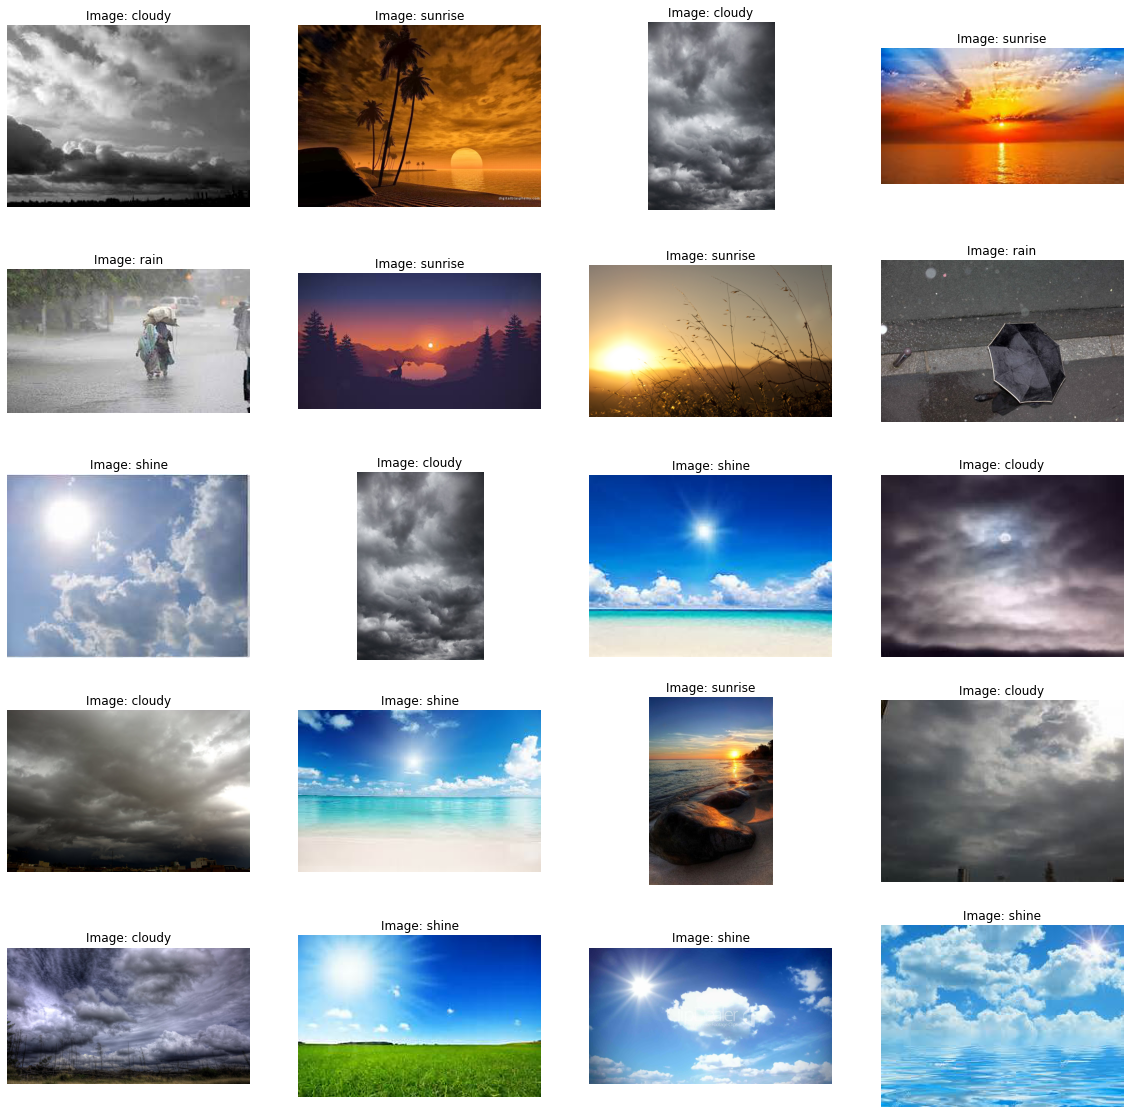

In [3]:
# previewing random images

def visualize_random_images(num_samples=20):
    plt.figure(figsize=(20, 20))
    for i in range(num_samples):
        random_idx = random.randint(0, len(images) - 1) 
        random_image = images[random_idx]
        
        filename = [key for key, value in label_map.items() if value == labels[random_idx]][0]
        
        # Displaying the image
        plt.subplot(5, num_samples/5, i + 1)
        plt.imshow(random_image)
        plt.title(f"Image: {filename}")
        plt.axis("off")
    plt.show()

visualize_random_images()


### 2.2.2) Weather Class Distribution

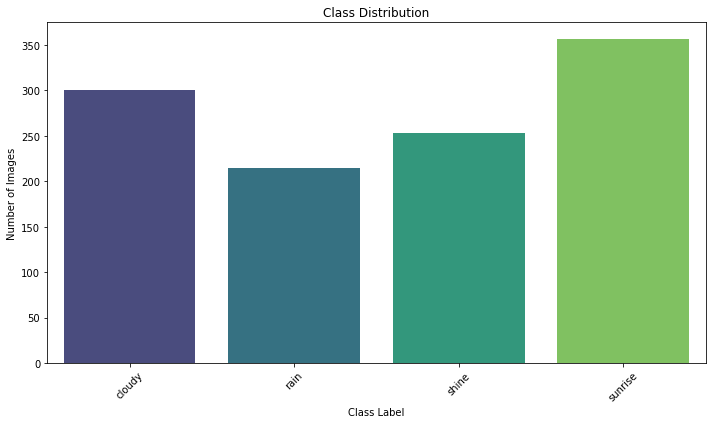

Counter({0: 300, 1: 215, 2: 253, 3: 357})

In [4]:
# class Distribution Visualization

# Get class titles from the label_map
class_titles = [key for key in label_map.keys()]

# Calculate class distribution using Counter
class_distribution = Counter(labels)

plt.figure(figsize=(10, 6))
sns.barplot(x=class_titles, y=list(class_distribution.values()), palette='viridis')
plt.xlabel("Class Label")
plt.ylabel("Number of Images")
plt.title("Class Distribution")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
class_distribution

Observation: The weather classes are relatively evenly distributed. There are 300 images showing cloudy weather, 215 images showing rainy weather, 253 images showing shinny weather, and 357 images showing sunrise. This shows class imbalance.

### 2.2.3) Image Size Distribution

Processing images: 100%|██████████| 1125/1125 [00:00<00:00, 3304.62it/s]


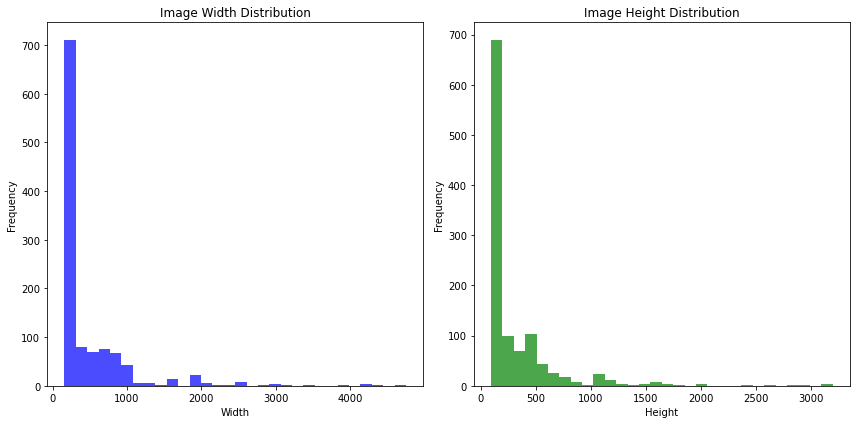

In [6]:
# image size distribution
image_sizes = []
for img_file in tqdm(os.listdir(dataset_path), desc='Processing images'):
    img_path = os.path.join(dataset_path, img_file)
    img = Image.open(img_path)
    width, height = img.size
    image_sizes.append((width, height))

widths, heights = zip(*image_sizes)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(widths, bins=30, color='blue', alpha=0.7)
plt.title('Image Width Distribution')
plt.xlabel('Width')
plt.ylabel('Frequency')
plt.subplot(1, 2, 2)
plt.hist(heights, bins=30, color='green', alpha=0.7)
plt.title('Image Height Distribution')
plt.xlabel('Height')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

Observation: The images have varying sizes (height and width).

### 2.2.4) Image Pixel Distribution

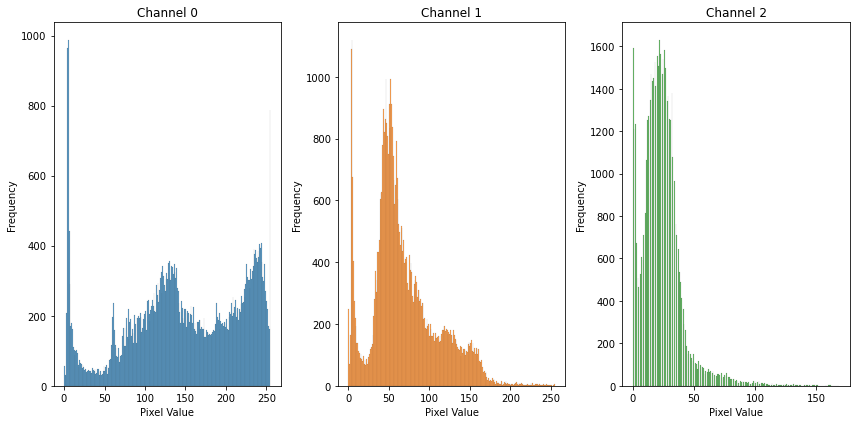

In [7]:
# Convert image to a NumPy array
img_array = np.array(img)

# Display pixel value distributions
plt.figure(figsize=(12, 6))

# Plot histograms for each color channel
for i in range(img_array.shape[2]):
    plt.subplot(1, 3, i + 1)
    sns.histplot(img_array[:, :, i].ravel(), bins=256, color=f'C{i}', alpha=0.7)
    plt.title(f'Channel {i}')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')

plt.tight_layout()

Observation: the RGB color distribution 

### 2.2.5) Label Mappings

In [8]:
# viewing label mappings
for key, value in label_map.items():
    print(f"{key} : {value}")

cloudy : 0
rain : 1
shine : 2
sunrise : 3


## 2.3) Data Preprocessing

### 2.3.1) Splitting the Data

In [9]:
# Setting the paths for the train, test, and validation directories
train_imgs = "./data/traindataset/"
test_imgs = "./data/testdataset/"
val_imgs = "./data/valdataset/"

# Defining split ratios
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15


# Creating directories
os.makedirs(train_imgs, exist_ok=True)
os.makedirs(test_imgs, exist_ok=True)
os.makedirs(val_imgs, exist_ok=True)

# Splitting the DataFrame into train, validation, and test sets
train_df, df_2 = train_test_split(df, train_size=train_ratio, random_state=42, shuffle=True)
val_df, test_df = train_test_split(df_2, test_size=val_ratio/(test_ratio+val_ratio), random_state=42, shuffle=True)

# Function to copy/move files to subdirectories based on weather classes
def organize_images_by_weather_classes(file_list, source_dir, destination_dir, classes):
    for weather_class in classes:
        os.makedirs(os.path.join(destination_dir, weather_class), exist_ok=True)

    for filepath, label in zip(file_list['filepaths'], file_list['word_labels']):
        filename = os.path.basename(filepath)
        weather_class = label.lower()
        if weather_class in classes:
            destination_path = os.path.join(destination_dir, weather_class, filename)
            shutil.copy(filepath, destination_path)

# Copying and organizing images to train directory by weather classes
organize_images_by_weather_classes(train_df, dataset_path, train_imgs, weather_classes)

# Copying and organizing images to validation directory by weather classes
organize_images_by_weather_classes(val_df, dataset_path, val_imgs, weather_classes)

# Copying and organizing images to test directory by weather classes
organize_images_by_weather_classes(test_df, dataset_path, test_imgs, weather_classes)

# Function to count number of images in each subdirectory
def count_images_in_subdirectories(parent_directory, classes):
    image_extensions = ['.jpg', '.jpeg', '.png', '.gif', '.bmp']

    # Dictionary to store image counts for each class
    image_counts = {cls: 0 for cls in classes}

    # Iterating through each class directory and counting images
    for cls in classes:
        directory_path = os.path.join(parent_directory, cls)
        if os.path.exists(directory_path):
            for filename in os.listdir(directory_path):
                if any(filename.lower().endswith(ext) for ext in image_extensions):
                    image_counts[cls] += 1

    return image_counts

# Getting the count of images in each subdirectory
num_train_images = count_images_in_subdirectories(train_imgs, weather_classes)
num_val_images = count_images_in_subdirectories(val_imgs, weather_classes)
num_test_images = count_images_in_subdirectories(test_imgs, weather_classes)

# Displaying number of images in each class within directories
for cls in weather_classes:
    print(f"There are {num_train_images[cls]} {cls} images in the training set")
    print(f"There are {num_val_images[cls]} {cls} images in the validation set")
    print(f"There are {num_test_images[cls]} {cls} images in the test set")

There are 209 cloudy images in the training set
There are 45 cloudy images in the validation set
There are 46 cloudy images in the test set
There are 143 rain images in the training set
There are 33 rain images in the validation set
There are 39 rain images in the test set
There are 178 shine images in the training set
There are 37 shine images in the validation set
There are 38 shine images in the test set
There are 257 sunrise images in the training set
There are 54 sunrise images in the validation set
There are 46 sunrise images in the test set


### 2.3.1) Image Generation

### 2.3.2) Image Data Augmentation

In [10]:
# data augmentation and flow_from_directory
target_width = int(np.mean(widths))
target_height = int(np.mean(heights))
img_size = (target_width, target_height)
channels = 3

train_data_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)
val_data_gen = ImageDataGenerator(rescale=1./255)

test_data_gen = ImageDataGenerator(rescale=1./255)

batch_size = 16

# Flowing data from directories
train_gen = train_data_gen.flow_from_directory(train_imgs, target_size=img_size, class_mode='categorical',
                                               color_mode='rgb', shuffle=True, batch_size=batch_size)

valid_gen = val_data_gen.flow_from_directory(val_imgs, target_size=img_size, class_mode='categorical',
                                             color_mode='rgb', shuffle=True, batch_size=batch_size)

test_gen = test_data_gen.flow_from_directory(test_imgs, target_size=img_size, class_mode='categorical',
                                             color_mode='rgb', shuffle=True, batch_size=batch_size)

Found 787 images belonging to 4 classes.
Found 169 images belonging to 4 classes.
Found 169 images belonging to 4 classes.


In [27]:
# Test data
test_data_gen = ImageDataGenerator(rescale=1./255)

test_gen = test_data_gen.flow_from_directory(test_imgs, target_size=img_size, class_mode='categorical',
                                             color_mode='rgb', shuffle=True, batch_size=batch_size)

Found 169 images belonging to 4 classes.


In [11]:
# Class weights to solve for class imbalance

class_weights = compute_class_weight('balanced', np.unique(train_gen.classes), train_gen.classes)
class_weights_dict = dict(enumerate(class_weights))

c:\Users\Dominc\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass classes=[0 1 2 3], y=[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 

## 2.4) Building Model

In [12]:
# Creating an ANN model
ann_model = Sequential([
    Flatten(input_shape=(target_width, target_height, 3)), 
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(weather_classes), activation='softmax')
])

# Compiling the model
ann_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Displaying the model summary
ann_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 507012)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               64897664  
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 516       
Total params: 64,898,180
Trainable params: 64,898,180
Non-trainable params: 0
_________________________________________________________________


In [13]:
test_loss2, test_accuracy2 = ann_model.evaluate(test_gen)
print(f"Test Accuracy: {test_accuracy2 * 100:.2f}%")

11/11 [==============================] - 3s 253ms/step - loss: 1.8089 - accuracy: 0.2189
Test Accuracy: 21.89%


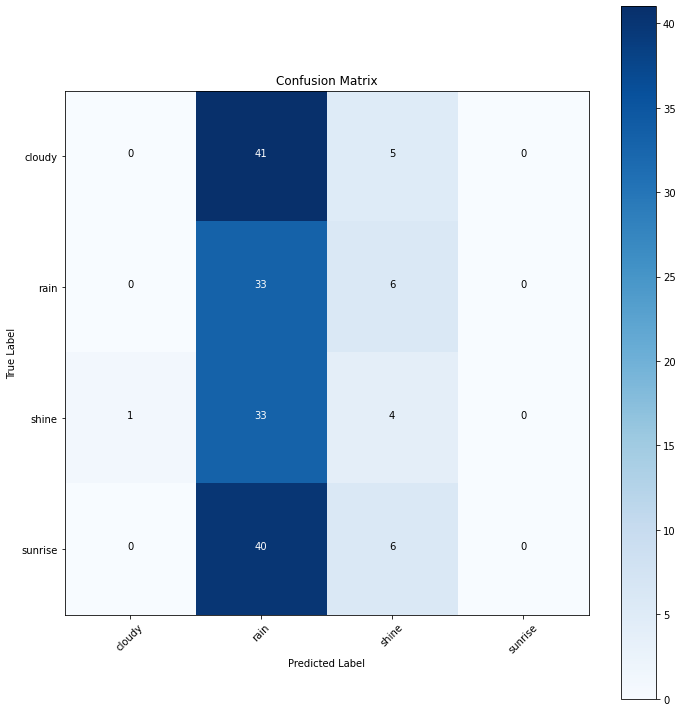

In [19]:
# Confusion Matix

# Making predictions on the test data
y_pred = ann_model.predict(test_gen)

# Getting the class indices and classes
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, np.argmax(y_pred, axis=1))

plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [20]:
# Printing Classification Report

# Get the class indices and classes
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Transform the predictions to class labels
y_pred_labels = [classes[np.argmax(pred)] for pred in y_pred]

# Get the true labels
true_labels = [classes[i] for i in test_gen.classes]

# Generate classification report
report = classification_report(true_labels, y_pred_labels)
print(report)

              precision    recall  f1-score   support

      cloudy       0.00      0.00      0.00        46
        rain       0.22      0.85      0.35        39
       shine       0.19      0.11      0.14        38
     sunrise       0.00      0.00      0.00        46

    accuracy                           0.22       169
   macro avg       0.10      0.24      0.12       169
weighted avg       0.09      0.22      0.11       169



c:\Users\Dominc\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [21]:
# Creating a CNN model with increased depth
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(target_width, target_height, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'), 
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(weather_classes), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Training the model
history = model.fit(train_gen, epochs=10, validation_data=valid_gen, class_weight=class_weights_dict)

Epoch 1/10
50/50 [==============================] - 156s 3s/step - loss: 1.0707 - accuracy: 0.5426 - val_loss: 0.8146 - val_accuracy: 0.6213
Epoch 2/10
50/50 [==============================] - 116s 2s/step - loss: 0.8092 - accuracy: 0.6518 - val_loss: 0.5734 - val_accuracy: 0.7811
Epoch 3/10
50/50 [==============================] - 118s 2s/step - loss: 0.5962 - accuracy: 0.8056 - val_loss: 0.4699 - val_accuracy: 0.8402
Epoch 4/10
50/50 [==============================] - 120s 2s/step - loss: 0.6090 - accuracy: 0.7903 - val_loss: 0.4220 - val_accuracy: 0.8817
Epoch 5/10
50/50 [==============================] - 119s 2s/step - loss: 0.4648 - accuracy: 0.8551 - val_loss: 0.4104 - val_accuracy: 0.8580
Epoch 6/10
50/50 [==============================] - 142s 3s/step - loss: 0.4306 - accuracy: 0.8615 - val_loss: 0.4683 - val_accuracy: 0.8580
Epoch 7/10
50/50 [==============================] - 148s 3s/step - loss: 0.3995 - accuracy: 0.8793 - val_loss: 0.6567 - val_accuracy: 0.8107
Epoch 8/10
50

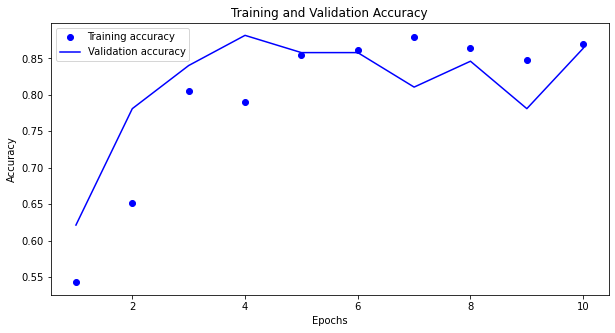

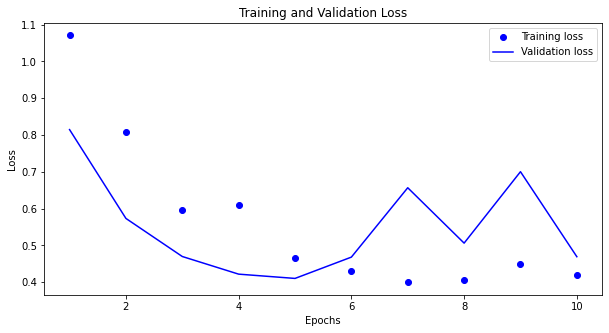

In [22]:
# Plotting History

# Extracting metrics from the history object
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# Plotting accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plotting loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [23]:
# Evaluating the model on the test set
test_loss, test_accuracy = model.evaluate(test_gen)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

11/11 [==============================] - 4s 365ms/step - loss: 0.4580 - accuracy: 0.8521
Test Accuracy: 85.21%


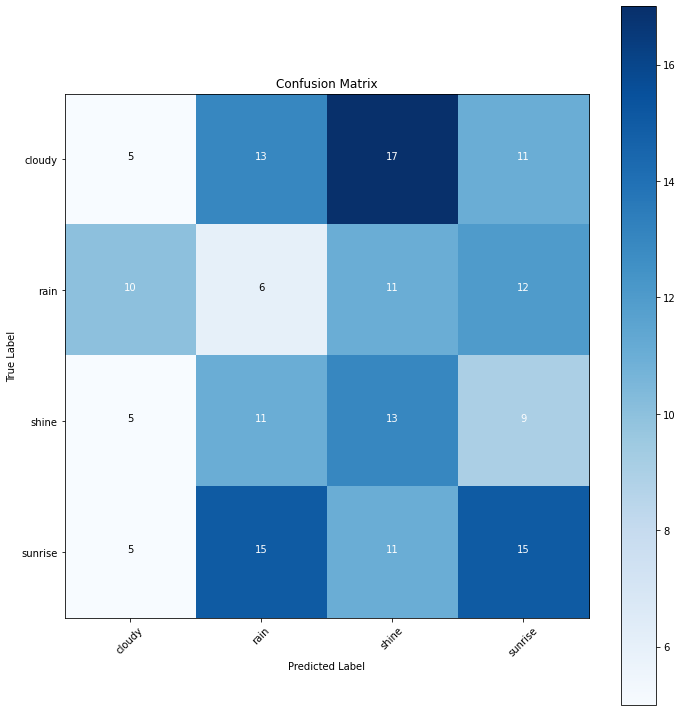

In [25]:
# Confusion Matix

# Making predictions on the test data
y_pred = model.predict(test_gen)

# Getting the class indices and classes
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, np.argmax(y_pred, axis=1))

plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [26]:
# Printing Classification Report

# Get the class indices and classes
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Transform the predictions to class labels
y_pred_labels = [classes[np.argmax(pred)] for pred in y_pred]

# Get the true labels
true_labels = [classes[i] for i in test_gen.classes]

# Generate classification report
report = classification_report(true_labels, y_pred_labels)
print(report)


              precision    recall  f1-score   support

      cloudy       0.20      0.11      0.14        46
        rain       0.13      0.15      0.14        39
       shine       0.25      0.34      0.29        38
     sunrise       0.32      0.33      0.32        46

    accuracy                           0.23       169
   macro avg       0.23      0.23      0.22       169
weighted avg       0.23      0.23      0.22       169



In [21]:
# Second Model
model1 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(target_width, target_height, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(len(weather_classes), activation='softmax')
])
# Compiling the model
model1.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history1 = model1.fit(train_gen, epochs=25, validation_data=valid_gen)

Epoch 1/25
50/50 [==============================] - 135s 3s/step - loss: 1.3428 - accuracy: 0.6290 - val_loss: 0.5777 - val_accuracy: 0.7633
Epoch 2/25
50/50 [==============================] - 171s 3s/step - loss: 0.5476 - accuracy: 0.8018 - val_loss: 0.4655 - val_accuracy: 0.8225
Epoch 3/25
50/50 [==============================] - 229s 5s/step - loss: 0.4601 - accuracy: 0.8310 - val_loss: 0.3624 - val_accuracy: 0.8698
Epoch 4/25
50/50 [==============================] - 416s 8s/step - loss: 0.3832 - accuracy: 0.8551 - val_loss: 0.3311 - val_accuracy: 0.9053
Epoch 5/25
50/50 [==============================] - 186s 4s/step - loss: 0.3520 - accuracy: 0.8691 - val_loss: 0.3073 - val_accuracy: 0.8935
Epoch 6/25
50/50 [==============================] - 470s 9s/step - loss: 0.3390 - accuracy: 0.8882 - val_loss: 0.3220 - val_accuracy: 0.8876
Epoch 7/25
50/50 [==============================] - 435s 9s/step - loss: 0.4170 - accuracy: 0.8399 - val_loss: 0.4774 - val_accuracy: 0.8521
Epoch 8/25
50

In [22]:
# Evaluating the model on the test set
test_loss1, test_accuracy1 = model1.evaluate(test_gen)
print(f"Test Accuracy1: {test_accuracy1 * 100:.2f}%")

11/11 [==============================] - 6s 527ms/step - loss: 0.4186 - accuracy: 0.8757
Test Accuracy1: 87.57%


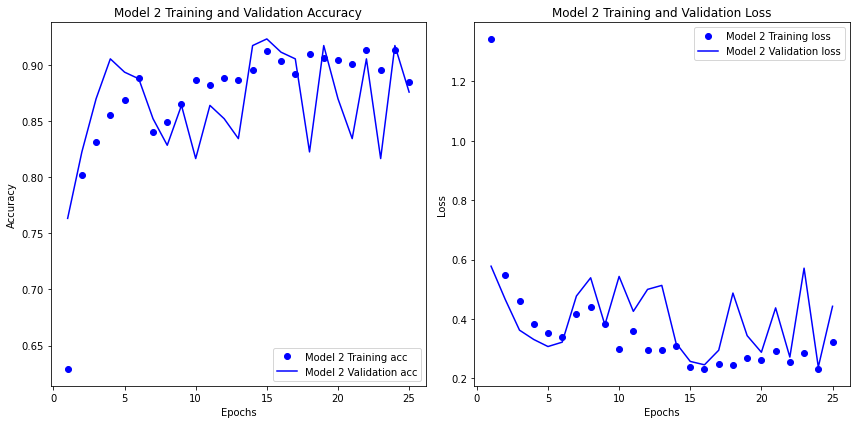

In [41]:
# Plotting history1

# Extracting metrics from the history object for model1
acc1 = history1.history['accuracy']
val_acc1 = history1.history['val_accuracy']
loss1 = history1.history['loss']
val_loss1 = history1.history['val_loss']
epochs1 = range(1, len(acc1) + 1)

# Plotting accuracy for model1
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs1, acc1, 'bo', label='Model 2 Training acc')
plt.plot(epochs1, val_acc1, 'b', label='Model 2 Validation acc')
plt.title('Model 2 Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting loss for model1
plt.subplot(1, 2, 2)
plt.plot(epochs1, loss1, 'bo', label='Model 2 Training loss')
plt.plot(epochs1, val_loss1, 'b', label='Model 2 Validation loss')
plt.title('Model 2 Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

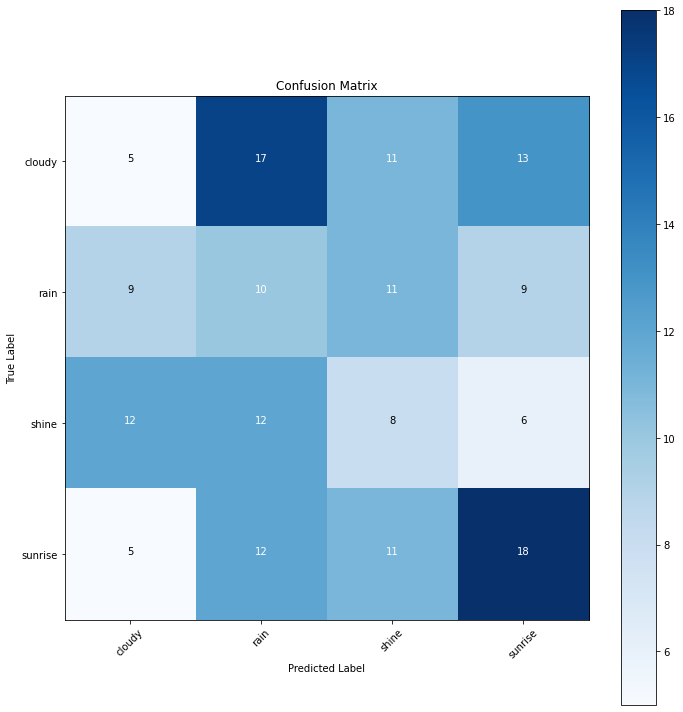

In [42]:
# Confusion Matix

# Making predictions on the test data
y_pred = model1.predict(test_gen)

# Getting the class indices and classes
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, np.argmax(y_pred, axis=1))

plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [43]:
# Printing Classification Report

# Get the class indices and classes
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Transform the predictions to class labels
y_pred_labels = [classes[np.argmax(pred)] for pred in y_pred]

# Get the true labels
true_labels = [classes[i] for i in test_gen.classes]

# Generate classification report
report = classification_report(true_labels, y_pred_labels)
print(report)

              precision    recall  f1-score   support

      cloudy       0.16      0.11      0.13        46
        rain       0.20      0.26      0.22        39
       shine       0.20      0.21      0.20        38
     sunrise       0.39      0.39      0.39        46

    accuracy                           0.24       169
   macro avg       0.24      0.24      0.24       169
weighted avg       0.24      0.24      0.24       169



In [ ]:
# Saving the best model
# model1.save('Weather_Recognition_Model.h5')

## 2.5) Conclusion

## 2.6) Recommendation